**1- INTEGRACION Y ANALISIS PRINCIPAL DEL DATASET**

In [ ]:
import pandas as pd

archivo = "Base_Pasantes.xlsx"

# 1. Cargar las hojas
datos = pd.read_excel(archivo, sheet_name="Datos", engine="openpyxl")
hoja1 = pd.read_excel(archivo, sheet_name="Hoja 1", engine="openpyxl")

# 2. Normalizar texto (quita espacios y pone en minúsculas para comparar bien)
datos["alumno"] = datos["alumno"].astype(str).str.strip().str.lower()
hoja1["Alumno"] = hoja1["Alumno"].astype(str).str.strip().str.lower()

# 3. Unir por coincidencia de nombres (inner join = solo alumnos que estén en ambas)
unido = datos.merge(
    hoja1,
    left_on="alumno",
    right_on="Alumno",
    how="inner"
)

# 4. Eliminar las dos columnas originales y dejar una sola
unido = unido.drop(columns=["Alumno"])
unido = unido.rename(columns={"alumno": "Alumno"})  # nombre final en mayúscula

# 5. Guardar el resultado
unido.to_excel("Base_Pasantes_unido.xlsx", index=False, engine="openpyxl")

print("Archivo creado: Base_Pasantes_unido.xlsx")
print("Dimensiones:", unido.shape)
print("Columnas:", unido.columns.tolist())

Archivo creado: Base_Pasantes_unido.xlsx
Dimensiones: (40786, 41)
Columnas: ['Alumno', 'Año académico', 'Espacio', 'Propuesta', 'Modalidad', 'Ubicación', 'sexo', 'fecha_nacimiento', 'nivel_estudio', 'titulo', 'estado_civil', 'cantidad_hijos', 'cantidad_familia', 'tipo_vivienda', 'vive_con', 'Localidad periodo lectivo', 'Departamento periodo lectivo', 'Provinvia periodo lectivo', 'trabajo_existe', 'trabajo_hace', 'trabajo_ocupacion', 'trabajo_hora_sem', 'trabajo_carrera', 'Fecha inscripción', 'Período ingreso', 'Calidad actual', 'motivo_cambio', 'Nota cursada', 'total_actas', 'cant_aprobado', 'cant_reprobado', 'cant_ausente', 'Maximo nivel estudio de Padres', 'Situacion laboral padres', 'Costeo Estudios', 'Tiene Beca?', 'Internet?', 'PC', 'Posee Discapacidad?', 'Discapacidad', 'Idiomas']


In [ ]:


#  Dimensión y estructura
print("Dimensiones:", unido.shape)
print("\nTipos de datos:")
print(unido.dtypes.value_counts())

# Nulos y valores únicos
info_columnas = pd.DataFrame({
    "Tipo": unido.dtypes.astype(str),
    "Valores nulos (%)": (unido.isnull().mean() * 100).round(2),
    "Valores únicos": unido.nunique()
}).sort_values("Valores nulos (%)", ascending=False)

print("\n Top 20 columnas con más nulos:")
print(info_columnas.head(20))

#  Estadísticas de variables numéricas
print("\n Estadísticas numéricas:")
print(unido.describe().T)

#  Frecuencia de algunas categóricas relevantes
categoricas = ["sexo", "Modalidad", "Ubicación", "Propuesta",
               "Calidad actual", "Tiene Beca?", "trabajo_existe"]
for col in categoricas:
    if col in unido.columns:
        print(f"\nDistribución de {col}:")
        print(unido[col].value_counts(dropna=False).head(10))

print("\nDistribución de motivo_cambio:")
if "motivo_cambio" in unido.columns:
    print(unido["motivo_cambio"].value_counts(dropna=False).head(20))


Dimensiones: (40786, 41)

Tipos de datos:
object            34
float64            5
int64              1
datetime64[ns]     1
Name: count, dtype: int64

 Top 20 columnas con más nulos:
                                 Tipo  Valores nulos (%)  Valores únicos
trabajo_carrera                object              48.80               3
trabajo_hora_sem               object              47.35               4
trabajo_ocupacion              object              47.25               3
trabajo_hace                   object              46.02               4
titulo                         object              45.80             577
tipo_vivienda                  object              45.68               5
Nota cursada                  float64               9.61            2436
total_actas                   float64               9.61             103
cant_aprobado                 float64               9.61              65
cant_ausente                  float64               9.61              43
cant_reproba

**2- CREACIÓN DE VARIABLES OBJETIVO Y CLASIFICACIÓN DEL ESTADO ACADÉMICO**


In [ ]:
# Crear etiqueta es_pasivo
import numpy as np

def normalizar_columna(col):
    return col.astype(str).str.strip().str.upper()

es_pasivo = None

if "motivo_cambio" in unido.columns:
    motivo = normalizar_columna(unido["motivo_cambio"])
    # Casos de abandono/pausa
    abandono = {"ABANDONÓ", "PASIVO", "FALTA DE PAGO", "SUSPENSIÓN DE CLASES"}
    es_pasivo = np.where(motivo.isin(abandono), 1, 0)

elif "Calidad actual" in unido.columns:
    ca = normalizar_columna(unido["Calidad actual"])
    es_pasivo = np.where(ca == "PASIVO", 1, 0)

if es_pasivo is None:
    raise ValueError("No encontré ni 'motivo_cambio' ni 'Calidad actual' para crear es_pasivo.")

unido["es_pasivo"] = es_pasivo

print("\nChequeo es_pasivo creado:")
print(unido["es_pasivo"].value_counts(dropna=False))
print("'es_pasivo' en columnas:", "es_pasivo" in unido.columns)


Chequeo es_pasivo creado:
es_pasivo
0    34896
1     5890
Name: count, dtype: int64
'es_pasivo' en columnas: True


In [ ]:
# Etiquetas a partir de motivo_cambio
motivo = unido["motivo_cambio"].astype(str).str.strip().str.upper()

def clasificar_estado(v):
    if v in ["EGRESO", "EMISIÓN DE CERTIFICACIÓN DE GRADUADOS/AS"]:
        return "Egresado"
    elif v in ["ABANDONÓ", "PASIVO", "FALTA DE PAGO", "SUSPENSIÓN DE CLASES"]:
        return "Pasivo"
    else:
        return "Activo"

unido["estado_final"] = motivo.apply(clasificar_estado)

# Binarios derivados
unido["es_pasivo"]    = (unido["estado_final"] == "Pasivo").astype(int)
unido["es_egresado"]  = (unido["estado_final"] == "Egresado").astype(int)

print("\nDistribución estado_final:")
print(unido["estado_final"].value_counts())
print("\nDistribución es_pasivo:")
print(unido["es_pasivo"].value_counts(normalize=True))
print("\nDistribución es_egresado:")
print(unido["es_egresado"].value_counts(normalize=True))


Distribución estado_final:
estado_final
Activo      22057
Egresado    12839
Pasivo       5890
Name: count, dtype: int64

Distribución es_pasivo:
es_pasivo
0    0.855588
1    0.144412
Name: proportion, dtype: float64

Distribución es_egresado:
es_egresado
0    0.685211
1    0.314789
Name: proportion, dtype: float64


**3- MODELO PREDICTIVO MULTICLASE PASIVO/ACTIVO/EGRESADO**

In [ ]:

#  MODELADO GENERAL: EGRESO / NO EGRESO


# === MODELADO con es_pasivo ===
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Verificamos que la columna 'estado_final' exista
if "estado_final" not in unido.columns:
    raise ValueError("No existe la columna 'estado_final'. Creala antes con el bloque de motivo_cambio.")

# Variables predictoras
features = [
    "sexo", "Modalidad", "Ubicación", "Propuesta", "Tiene Beca?",
    "trabajo_existe", "total_actas", "cant_aprobado", "Nota cursada"
]

# Dataset filtrado
df_modelo_multi = unido[features + ["estado_final"]].dropna(subset=["estado_final"]).copy()



In [ ]:

# 2️ Separar variables numéricas y categóricas

num_vars = df_modelo_multi.select_dtypes(include=["int64", "float64"]).columns
cat_vars = df_modelo_multi.select_dtypes(include=["object"]).columns.drop("estado_final")

In [ ]:

# 3️ Preparar preprocesamiento

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_vars),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_vars)
])

In [ ]:

# 4 Dividir en train y test

X = df_modelo_multi[features]
y = df_modelo_multi["estado_final"]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:

# 5️ Entrenar modelo base multiclase

modelo_multi = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Entrenamiento
modelo_multi.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['total_actas', 'cant_aprobado', 'Nota cursada'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['sexo', 'Modalidad', 'Ubicación', 'Propuesta', 'Tiene Beca?',
       'trabajo_existe'],
      dtype='object'))])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

=== Reporte Multiclase ===
              precision    recall  f1-score   support

      Activo       0.86      0.77      0.82      5514
    Egresado       0.87      0.92      0.89      3210
      Pasivo       0.56      0.71      0.63      1473

    accuracy                           0.81     10197
   macro avg       0.77      0.80      0.78     10197
weighted avg       0.82      0.81      0.81     10197



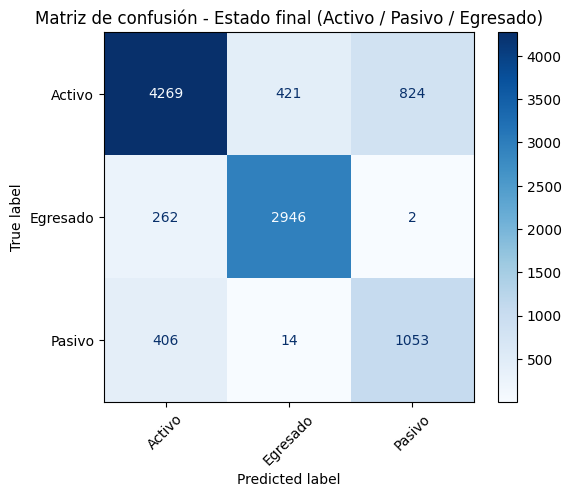

In [ ]:

# 6️ Evaluar desempeño

y_pred = modelo_multi.predict(X_test)

# Evaluación
print("=== Reporte Multiclase ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=modelo_multi.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_multi.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Estado final (Activo / Pasivo / Egresado)")
plt.show()

In [ ]:

# 7️ Importancia de variables

enc = modelo_multi.named_steps["prep"].named_transformers_["cat"].named_steps["enc"]
cat_names = enc.get_feature_names_out(cat_vars)
all_features = np.concatenate([num_vars, cat_names])

importancias = modelo_multi.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({
    "Variable": all_features,
    "Importancia": importancias
}).sort_values("Importancia", ascending=False)

print("\n=== Variables más influyentes (RF multiclase) ===")
display(imp_df.head(15))


=== Variables más influyentes (RF multiclase) ===


,Variable,Importancia
2,Nota cursada,0.334934
1,cant_aprobado,0.228978
0,total_actas,0.204647
36,Propuesta_LICENCIATURA EN PSICOPEDAGOGÍA - CIC...,0.017515
30,Propuesta_LICENCIATURA EN KINESIOLOGÍA Y FISIA...,0.017186
12,Ubicación_ROSARIO,0.011005
14,Ubicación_ROSARIO-RT,0.010583
56,trabajo_existe_Trabajó al menos una hora (incl...,0.009810
55,trabajo_existe_No trabajó y no buscó trabajo (...,0.008630
6,Modalidad_A distancia,0.008290


**4- ANÁLISIS DE DISTRIBUCIÓN DE CLASES Y VALIDACIÓN DE LOS CONJUNTOS DE ENTRENAMIENTO Y PRUEBA**

In [ ]:
# Distribución global
print("GLOBAL:")
print(unido["estado_final"].value_counts())

# Distribución en train/test
print("\nTRAIN:")
print(y_train.value_counts())
print("\nTEST:")
print(y_test.value_counts())

print("\nPorcentajes TEST:")
print(y_test.value_counts(normalize=True).round(3))

GLOBAL:
estado_final
Activo      22057
Egresado    12839
Pasivo       5890
Name: count, dtype: int64

TRAIN:
estado_final
Activo      16543
Egresado     9629
Pasivo       4417
Name: count, dtype: int64

TEST:
estado_final
Activo      5514
Egresado    3210
Pasivo      1473
Name: count, dtype: int64

Porcentajes TEST:
estado_final
Activo      0.541
Egresado    0.315
Pasivo      0.144
Name: proportion, dtype: float64


**5- MODELO GENERAL DE EGRESO**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score


In [ ]:
# 1 Preparación de datos
df_modelo = unido.copy()
df_modelo["es_egresado"] = np.where(df_modelo["estado_final"] == "Egresado", 1, 0)

features = [
    "sexo", "Modalidad", "Ubicación", "Propuesta", "Tiene Beca?",
    "trabajo_existe", "total_actas", "cant_aprobado", "Nota cursada"
]

df_modelo = df_modelo[features + ["es_egresado"]].dropna(subset=["es_egresado"])


In [ ]:
# 2 Función general de entrenamiento y análisis

def entrenar_y_evaluar(df, target_col="es_egresado", nombre="General"):
    X = df.drop(columns=target_col)
    y = df[target_col]

    num_vars = X.select_dtypes(include=["int64", "float64"]).columns
    cat_vars = X.select_dtypes(include=["object"]).columns

    preprocessor = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num_vars),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("enc", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_vars)
    ])

    modelo = Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced",
            n_jobs=-1
        ))
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.25, random_state=42
    )

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    print(f"\n\n====== {nombre.upper()} ======")
    print("Accuracy:", round(modelo.score(X_test, y_test), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, zero_division=0))

    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()

    enc = modelo.named_steps["prep"].named_transformers_["cat"].named_steps["enc"]
    cat_names = enc.get_feature_names_out(cat_vars)
    all_features = np.concatenate([num_vars, cat_names])

    importancias = pd.DataFrame({
        "Variable": all_features,
        "Importancia": modelo.named_steps["clf"].feature_importances_
    }).sort_values("Importancia", ascending=False)

    return modelo, importancias, X_test, y_test




====== GENERAL ======
Accuracy: 0.935
ROC AUC: 0.973

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      6987
           1       0.87      0.93      0.90      3210

    accuracy                           0.94     10197
   macro avg       0.92      0.93      0.93     10197
weighted avg       0.94      0.94      0.94     10197



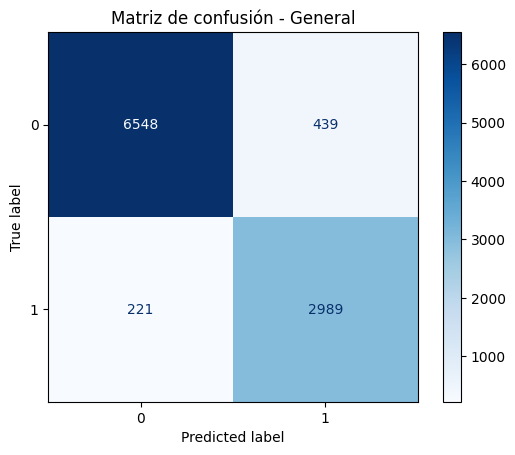

In [ ]:
# 3 Entrenamiento del modelo general
modelo_general, imp_general, X_test, y_test = entrenar_y_evaluar(df_modelo, nombre="General")


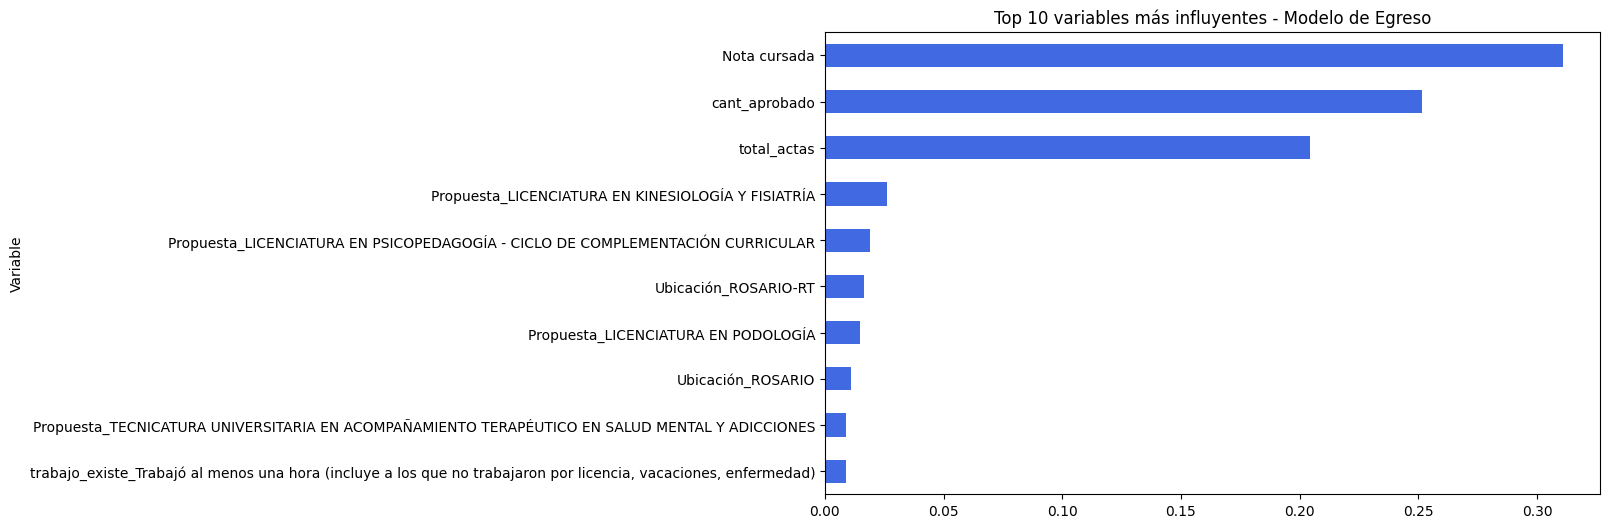

In [ ]:
# 4 Visualización de variables más influyentes
imp_general.head(10).plot(
    x="Variable", y="Importancia", kind="barh", figsize=(10,6), legend=False, color="royalblue"
)
plt.title("Top 10 variables más influyentes - Modelo de Egreso")
plt.gca().invert_yaxis()
plt.show()


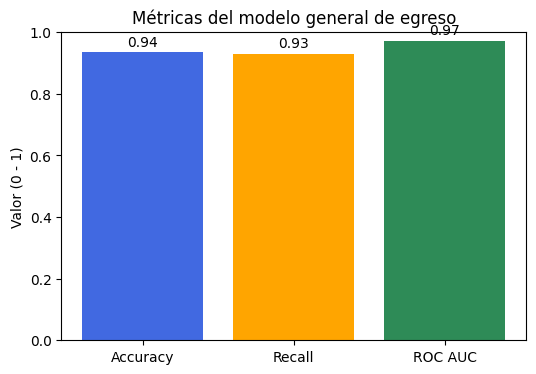


=== MÉTRICAS FINALES ===
Accuracy: 0.935
Recall: 0.931
ROC AUC: 0.973


In [ ]:
# 5 Evaluación general de métricas
y_pred = modelo_general.predict(X_test)
y_prob = modelo_general.predict_proba(X_test)[:, 1]

metricas = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 3),
    "Recall": round(recall_score(y_test, y_pred), 3),
    "ROC AUC": round(roc_auc_score(y_test, y_prob), 3)
}

plt.figure(figsize=(6,4))
plt.bar(metricas.keys(), metricas.values(), color=["royalblue", "orange", "seagreen"])
plt.title("Métricas del modelo general de egreso")
plt.ylabel("Valor (0 - 1)")
plt.ylim(0, 1)
for i, val in enumerate(metricas.values()):
    plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=10)
plt.show()

print("\n=== MÉTRICAS FINALES ===")
for k, v in metricas.items():
    print(f"{k}: {v}")

In [ ]:
# 6 Guardar modelo e importancias
import joblib
modelo_general.named_steps["clf"].random_state = None
joblib.dump(modelo_general, "modelo_general_egreso.pkl")
imp_general.to_excel("Importancias_Variables_General.xlsx", index=False)
print("\nModelo e importancias guardados correctamente.")


Modelo e importancias guardados correctamente.


**6- ANÁLISIS DESCRIPTIVO DE LOS DESERTORES**


In [ ]:
df = pd.read_excel("Base_Pasantes.xlsx")

# 1 Filtrar carreras de Tecnicatura y Licenciatura
desertores = unido[
    (unido["estado_final"] == "Pasivo") &
    (unido["Propuesta"].str.contains("Tecnicatura|Licenciatura", case=False, na=False))
].copy()

print(f"Total de desertores analizados: {len(desertores)}")

Total de desertores analizados: 5540



--- Situación laboral (trabaja / no trabaja) ---
trabajo_existe
Trabajó al menos una hora (incluye a los que no trabajaron por licencia, vacaciones, enfermedad)    57.278241
No trabajó y no buscó trabajo (no esta pensando en trabajar)                                        29.435178
No trabajó y buscó trabajo en algún momento de los últimos 30 dí­as                                 13.040182
Desconoce                                                                                            0.246399
Name: proportion, dtype: float64


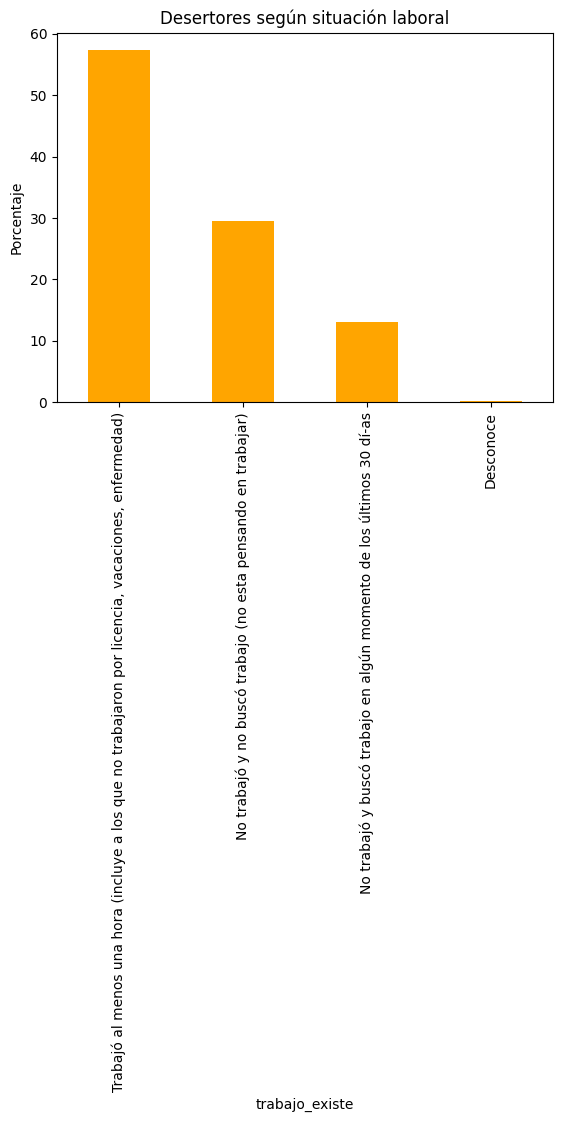

In [ ]:
# 2 Situación laboral
trabajo = desertores["trabajo_existe"].value_counts(normalize=True) * 100
print("\n--- Situación laboral (trabaja / no trabaja) ---")
print(trabajo)
trabajo.plot(kind="bar", color="orange", title="Desertores según situación laboral")
plt.ylabel("Porcentaje")
plt.show()



--- Con quién viven ---
vive_con
Con familia de origen (padres, hermanos, abuelos)    52.491961
Con su pareja/hijos                                  27.069936
Solo                                                 13.122990
Con compañeros                                        3.838424
Otros                                                 3.476688
Name: proportion, dtype: float64


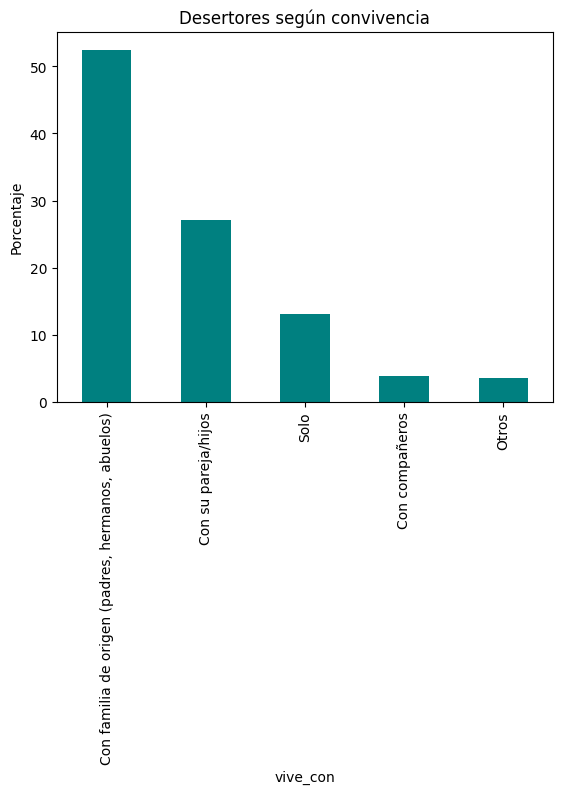

In [ ]:
# 3 Convivencia (vive con padres o no)
convivencia = desertores["vive_con"].value_counts(normalize=True) * 100
print("\n--- Con quién viven ---")
print(convivencia)
convivencia.plot(kind="bar", color="teal", title="Desertores según convivencia")
plt.ylabel("Porcentaje")
plt.show()

In [ ]:
# 4 Filtramos desertores reales: con al menos 3 materias aprobadas y nota válida > 0
desertores_filtrados = unido[
    (unido["estado_final"] == "Pasivo") &
    (unido["Propuesta"].str.contains("Tecnicatura|Licenciatura", case=False, na=False)) &
    (unido["cant_aprobado"] >= 3) &
    (unido["Nota cursada"] > 0)
].copy()

print(f"Total desertores analizados después del filtro: {len(desertores_filtrados)}")

print("\n--- Nuevos promedios académicos (filtrados) ---")
print(f"Nota cursada promedio: {desertores_filtrados['Nota cursada'].mean():.2f}")
print(f"Materias aprobadas promedio: {desertores_filtrados['cant_aprobado'].mean():.2f}")
print(f"Materias reprobadas promedio: {desertores_filtrados['cant_reprobado'].mean():.2f}")
print(f"Materias ausentes promedio: {desertores_filtrados['cant_ausente'].mean():.2f}")


Total desertores analizados después del filtro: 2246

--- Nuevos promedios académicos (filtrados) ---
Nota cursada promedio: 6.83
Materias aprobadas promedio: 11.85
Materias reprobadas promedio: 2.39
Materias ausentes promedio: 2.43


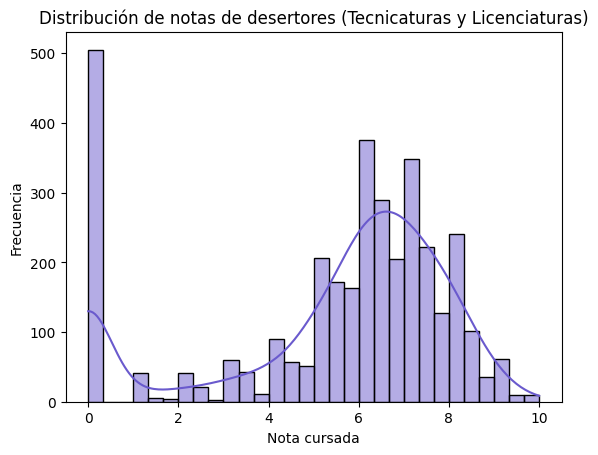

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 5 Distribución de notas
sns.histplot(desertores["Nota cursada"], kde=True, color="slateblue")
plt.title("Distribución de notas de desertores (Tecnicaturas y Licenciaturas)")
plt.xlabel("Nota cursada")
plt.ylabel("Frecuencia")
plt.show()


--- Comparación promedio entre Egresados y Pasivos ---
              Nota cursada  cant_aprobado  cant_reprobado
estado_final                                             
Egresado              7.75          26.79            0.71
Pasivo                5.42           7.66            1.79


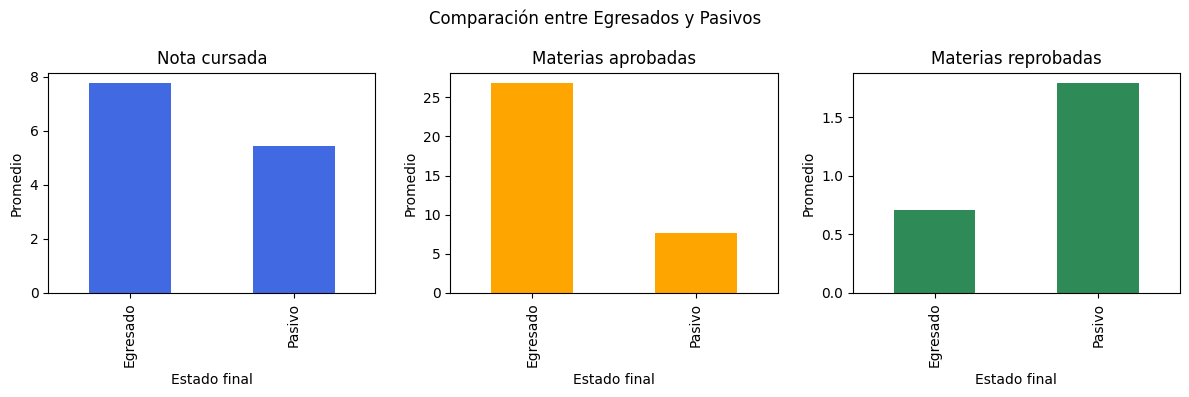

In [ ]:
# Crear la tabla comparativa de promedios
comparacion = (
    unido[unido["estado_final"].isin(["Egresado", "Pasivo"])]
    .groupby("estado_final")[["Nota cursada", "cant_aprobado", "cant_reprobado"]]
    .mean()
    .round(2)
)

print("\n--- Comparación promedio entre Egresados y Pasivos ---")
print(comparacion)



# 6 Comparativa general (Egresados vs Pasivos)
fig, axes = plt.subplots(1, 3, figsize=(12,4))

comparacion["Nota cursada"].plot(kind="bar", ax=axes[0], color="royalblue", title="Nota cursada")
comparacion["cant_aprobado"].plot(kind="bar", ax=axes[1], color="orange", title="Materias aprobadas")
comparacion["cant_reprobado"].plot(kind="bar", ax=axes[2], color="seagreen", title="Materias reprobadas")

for ax in axes:
    ax.set_xlabel("Estado final")
    ax.set_ylabel("Promedio")

plt.suptitle("Comparación entre Egresados y Pasivos")
plt.tight_layout()
plt.show()


**7- MODELO PREDICTIVO DE DESERCIÓN**


In [ ]:
# MODELO PREDICTIVO DE DESERCIÓN (ES_PASIVO)

# 1 Preparamos el dataset
df_desercion = unido.copy()
df_desercion["es_pasivo"] = np.where(df_desercion["estado_final"] == "Pasivo", 1, 0)

features = [
    "sexo", "Modalidad", "Ubicación", "Propuesta",
    "trabajo_existe", "trabajo_hora_sem", "trabajo_carrera",
    "total_actas", "cant_aprobado", "cant_reprobado", "cant_ausente",
    "Nota cursada", "tipo_vivienda", "vive_con", "Tiene Beca?"
]

df_desercion = df_desercion[features + ["es_pasivo"]].dropna(subset=["es_pasivo"])



====== DESERCIÓN ======
Accuracy: 0.903
ROC AUC: 0.924

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8724
           1       0.67      0.63      0.65      1473

    accuracy                           0.90     10197
   macro avg       0.81      0.79      0.80     10197
weighted avg       0.90      0.90      0.90     10197



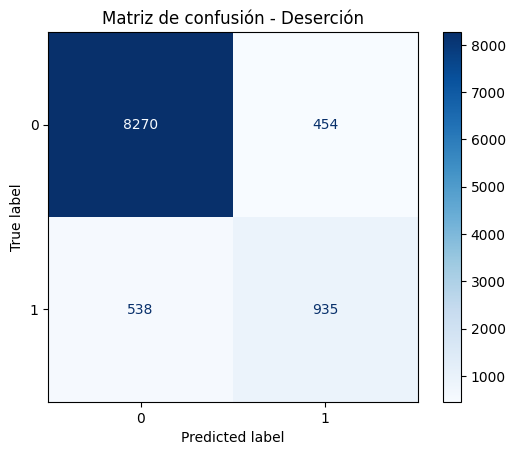

In [ ]:

# 2 Entrenamos el modelo usando tu función entrenar_y_evaluar
modelo_desercion, imp_desercion, X_test, y_test = entrenar_y_evaluar(df_desercion, target_col="es_pasivo", nombre="Deserción")




=== MÉTRICAS DEL MODELO DE DESERCIÓN ===
Accuracy: 0.903
Recall:   0.635
ROC AUC:  0.924

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8724
           1       0.67      0.63      0.65      1473

    accuracy                           0.90     10197
   macro avg       0.81      0.79      0.80     10197
weighted avg       0.90      0.90      0.90     10197



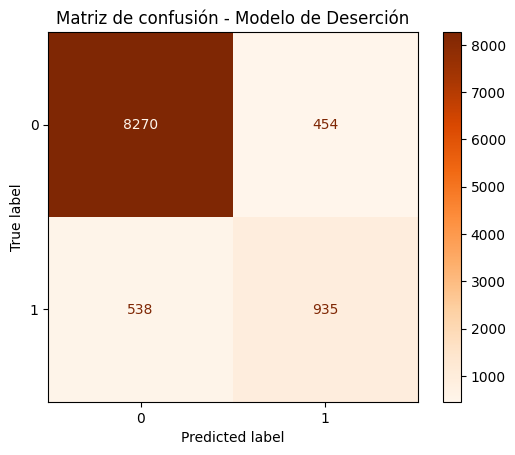

In [ ]:
# 3 Métricas y reporte
X = df_desercion.drop(columns="es_pasivo")
y = df_desercion["es_pasivo"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

y_pred = modelo_desercion.predict(X_test)
y_prob = modelo_desercion.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("\n=== MÉTRICAS DEL MODELO DE DESERCIÓN ===")
print(f"Accuracy: {acc:.3f}")
print(f"Recall:   {rec:.3f}")
print(f"ROC AUC:  {roc:.3f}")

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, zero_division=0))

ConfusionMatrixDisplay.from_estimator(modelo_desercion, X_test, y_test, cmap="Oranges")
plt.title("Matriz de confusión - Modelo de Deserción")
plt.show()


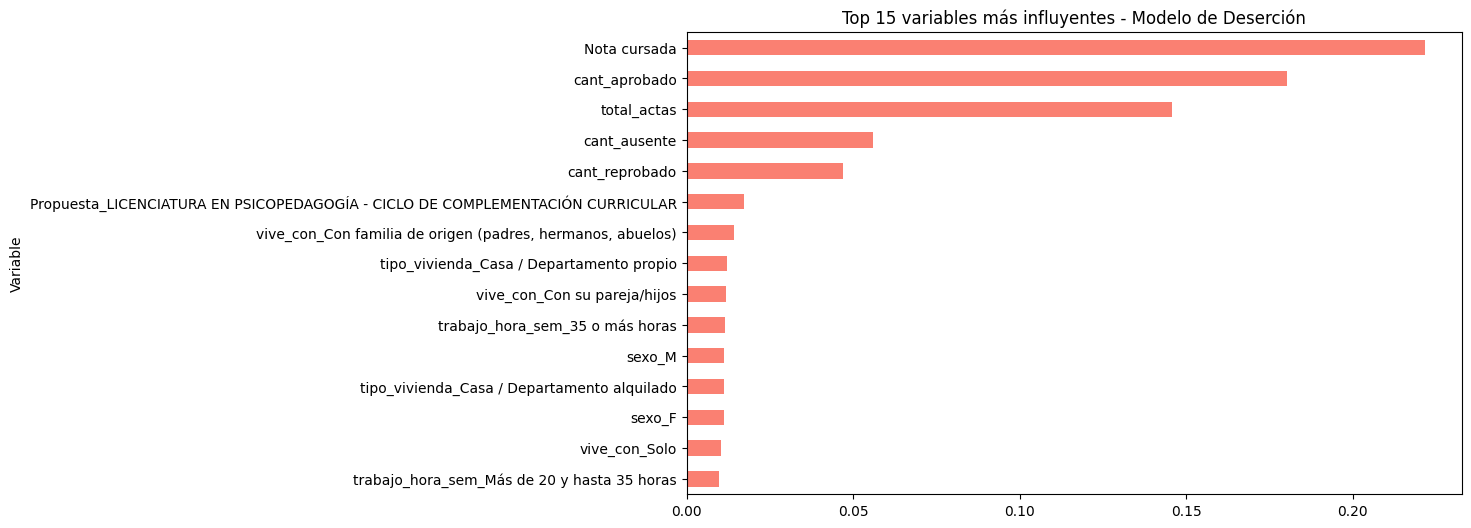

In [ ]:
# 4 Importancia de variables
imp_desercion.head(15).plot(
    x="Variable", y="Importancia", kind="barh", figsize=(10,6), legend=False, color="salmon"
)
plt.title("Top 15 variables más influyentes - Modelo de Deserción")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 5 Guardar modelo y resultados
modelo_desercion.named_steps["clf"].random_state = None
joblib.dump(modelo_desercion, "modelo_desercion.pkl")
imp_desercion.to_excel("Importancias_Variables_Desercion.xlsx", index=False)

print("\nModelo de deserción e importancias guardados correctamente.")


Modelo de deserción e importancias guardados correctamente.
